                                            
 ##             Lecture 16                    
                                            
Binary/Probability models                 
  - Saturated Probability Models          
    - calculate weights and               
        estimating models                 
    - plot a simple binary model          
    - predicted and true outcome          
  - Functional form decision              
  - Multiple Regression w binary outcome  
    - characteristics of predicted groups 
  - Logit and Probit models               
    - simple estimates                    
    - average marginal effects            
  - Model comparison of non-linear models 
    - Goodness-of-fit statistics:         
    R2, Pseudo-R2, Brier score, Log-loss  
    - Visual inspection:                  
    distribution of prediction by outcome 
    - summary stats for predictions       
        by outcome                        
    - Bias and calibration curve          
                                            
                                            
Case Study:                                 
  - Does Smoking Pose a Health Risk           
                                            
Dataset used:                               
  - share-health                            

Import packages

In [1]:
import pandas as pd
import numpy as np
from plotnine import *
from mizani.formatters import percent_format
import statsmodels.api as sm
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer

Import data

In [2]:
share = pd.read_csv("https://osf.io/3ze58/download")

Check all the data - quick description 

(All except country_str, but it is implied in country_mod)

In [3]:
share.describe()

,ID,wave,country,country_mod,int_year,int_month,female,age,sphus,br015,...,income10,bmi,mar_stat,healthy,baseline,endline,stayshealthy,married,exerc,eduyears
count,3272.000000,3272.0,3272.000000,3272.000000,3272.000000,3272.000000,3272.000000,3272.000000,3272.000000,3272.000000,...,3272.000000,3197.000000,3272.000000,3272.0,3272.0,3272.0,3272.000000,3272.000000,3271.000000,3184.000000
mean,1636.500000,4.0,20.311125,345.395171,2010.999389,6.143643,0.565403,55.207182,1.698350,2.013142,...,6.762225,25.536357,1.976467,1.0,1.0,0.0,0.599633,0.741137,0.520330,12.311401
std,944.689367,0.0,6.865731,273.018251,0.154420,2.560338,0.495780,2.792197,0.459044,1.253602,...,2.751671,3.904651,1.702695,0.0,0.0,0.0,0.490048,0.438077,0.499663,4.566385
min,1.000000,4.0,11.000000,40.000000,2010.000000,1.000000,0.000000,50.000000,1.000000,-12.000000,...,1.000000,16.326530,-12.000000,1.0,1.0,0.0,0.000000,0.000000,0.000000,0.000000
25%,818.750000,4.0,16.000000,56.000000,2011.000000,4.000000,0.000000,52.799999,1.000000,1.000000,...,5.000000,22.837370,1.000000,1.0,1.0,0.0,0.000000,0.000000,0.000000,10.000000
50%,1636.500000,4.0,18.000000,233.000000,2011.000000,6.000000,1.000000,55.299999,2.000000,1.000000,...,7.000000,25.099501,1.000000,1.0,1.0,0.0,1.000000,1.000000,1.000000,12.000000
75%,2454.250000,4.0,23.000000,705.000000,2011.000000,8.000000,1.000000,57.599998,2.000000,3.000000,...,9.000000,27.774424,3.000000,1.0,1.0,0.0,1.000000,1.000000,1.000000,16.000000
max,3272.000000,4.0,35.000000,756.000000,2012.000000,12.000000,1.000000,60.000000,2.000000,4.000000,...,10.000000,45.632774,6.000000,1.0,1.0,0.0,1.000000,1.000000,1.000000,25.000000


Remove if any of important variable is missing 

In [4]:
share = (
    share.loc[share["bmi"].notnull()]
    .loc[share["eduyears"].notnull()]
    .loc[share["exerc"].notnull()]
)

Make descriptive statistics for thery based selected variables

In [5]:
share.filter(
    [
        "stayshealthy",
        "smoking",
        "ever_smoked",
        "female",
        "age",
        "income10",
        "eduyears",
        "bmi",
        "exerc",
    ]
).describe().T

,count,mean,std,min,25%,50%,75%,max
stayshealthy,3109.0,0.604696,0.488995,0.00000,0.000000,1.000000,1.000000,1.000000
smoking,3109.0,0.223866,0.416900,0.00000,0.000000,0.000000,0.000000,1.000000
ever_smoked,3109.0,0.492120,0.500018,0.00000,0.000000,0.000000,1.000000,1.000000
female,3109.0,0.560952,0.496351,0.00000,0.000000,1.000000,1.000000,1.000000
age,3109.0,55.187617,2.788072,50.00000,52.799999,55.299999,57.500000,60.000000
income10,3109.0,6.790286,2.745141,1.00000,5.000000,7.000000,9.000000,10.000000
eduyears,3109.0,12.330814,4.556630,0.00000,10.000000,13.000000,16.000000,25.000000
bmi,3109.0,25.531596,3.905711,16.32653,22.837370,25.099501,27.774271,45.632774
exerc,3109.0,0.523963,0.499506,0.00000,0.000000,1.000000,1.000000,1.000000


## 1) Saturated Linear Probability Models

y is stayshealthy

Linear probability models of good health at endline and smoking


 1st model:current smoker on RHS

In [6]:
lpm1 = smf.ols("stayshealthy ~ smoking", data=share).fit(cov_type ="HC3")
lpm1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           stayshealthy   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     10.82
Date:                Wed, 20 Jul 2022   Prob (F-statistic):            0.00102
Time:                        18:10:50   Log-Likelihood:                -2181.2
No. Observations:                3109   AIC:                             4366.
Df Residuals:                    3107   BIC:                             4379.
Df Model:                           1                                         
Covariance Type:                  HC3                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.6204      0.010     62.771      0.000       0.601       0.640
smoking       -0.0701      0.021     -3.289      0.001      -0.112      -0.028
==============================================================================
Omnibus:                    12627.714   Durbin-Watson:                   1.845
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              515.339
Skew:                          -0.427   Prob(JB):                    1.25e-112
Kurtosis:                       1.197   Cond. No.                         2.54
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

Get the predicted values

In [7]:
share["pred1"] = lpm1.predict()

Compare smoking with predicted values and real outcomes

1) Predicted vs smoking


In [8]:
pd.crosstab(index=share["pred1"], columns=share["smoking"])

smoking,0,1
pred1,,
0.550287,0,696
0.620390,2413,0


In [9]:
pd.crosstab(index = share['stayshealthy'],columns= share['smoking'])

smoking,0,1
stayshealthy,,
0,916,313
1,1497,383


Create weights for prettier plot

In [10]:
share["weight"] = share.groupby(["smoking","stayshealthy"])["ID"].transform("count")
share["weight_2"] = share["weight"] / 1000

Show graph with actual and predicted probabilities: LPM


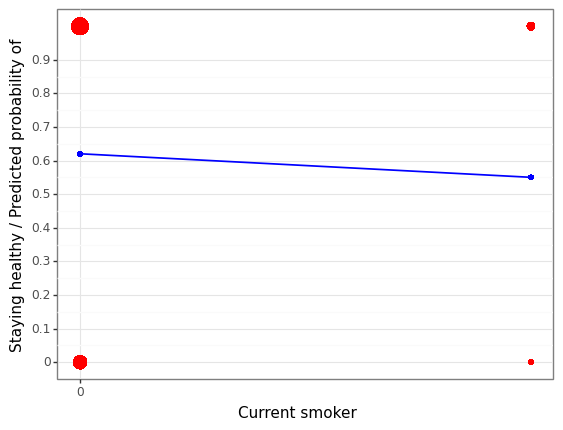

<ggplot: (362387033)>

In [11]:
(
    ggplot(share)
    + geom_point(aes(x="smoking", y="pred1"), size=1, color="blue")
    + geom_line(aes(x="smoking", y="pred1"), colour="blue", size=0.7)
    + geom_point(
        aes(x="smoking", y="stayshealthy", size="weight_2"),
        fill="red",
        color="red",
        alpha=0.8,
        na_rm=True,
    )
    + scale_size_continuous(guide=False)
    + labs(x="Current smoker", y="Staying healthy / Predicted probability of ")
    + coord_cartesian(xlim=(0, 1), ylim=(0, 1))
    + scale_y_continuous(limits=(0, 1), breaks=np.arange(0, 1, 0.1))
    + scale_x_continuous(limits=(0, 1), breaks=np.arange(0, 1, 1))
    + theme_bw()
)

2nd model: current smoker and ever smoked on RHS

In [12]:
lpm2 = smf.ols("stayshealthy ~ smoking + ever_smoked", data=share).fit(cov_type ="HC3")
lpm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           stayshealthy   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     5.655
Date:                Wed, 20 Jul 2022   Prob (F-statistic):            0.00354
Time:                        18:10:50   Log-Likelihood:                -2181.0
No. Observations:                3109   AIC:                             4368.
Df Residuals:                    3106   BIC:                             4386.
Df Model:                           2                                         
Covariance Type:                  HC3                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.6154      0.012     50.195      0.000       0.591       0.639
smoking        -0.0787      0.025     -3.194      0.001      -0.127      -0.030
ever_smoked     0.0140      0.020      0.693      0.488      -0.026       0.054
==============================================================================
Omnibus:                    12633.221   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              515.040
Skew:                          -0.426   Prob(JB):                    1.45e-112
Kurtosis:                       1.198   Cond. No.                         3.76
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity robust (HC3)
"""

Compare models

In [13]:
table = Stargazer([lpm1,lpm2])
table

 2) Multiple variable regressions:
     selecting multiple variables, when outcome is binary

 As usual: check some functional forms

 For pretty plots create weigths for education

In [14]:
share["weight"] = (
    share.groupby(["eduyears", "stayshealthy"])["smoking"].transform(len) / 100
)

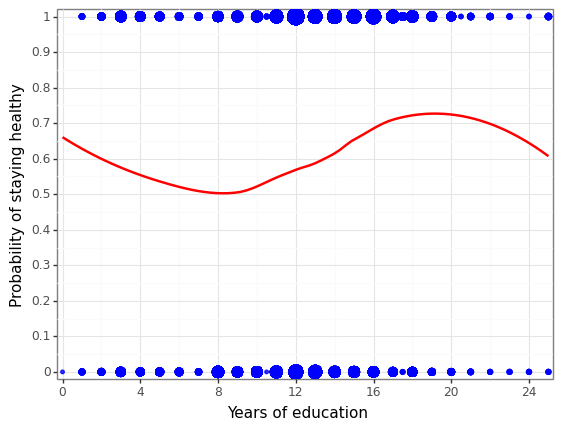

<ggplot: (362611199)>

In [15]:
g2 = (
    ggplot(data=share)
    + geom_point(
        aes(x="eduyears", y="stayshealthy", size="weight"),
        color="blue",
        alpha=0.8,
        na_rm=True,
    )
    + geom_smooth(
        aes(x="eduyears", y="stayshealthy"), method="loess", se=False, color="red"
    )
    + labs(x="Years of education", y="Probability of staying healthy ")
    + scale_x_continuous(
        expand=[0.01, 0.01], limits=[0, 25], breaks=np.arange(0, 25, 4)
    )
    + scale_y_continuous(
        expand=[0.01, 0.01], limits=[0, 1], breaks=np.arange(0, 1.1, 0.1)
    )
    + scale_size_continuous(guide=False)
    + theme_bw()
)
g2

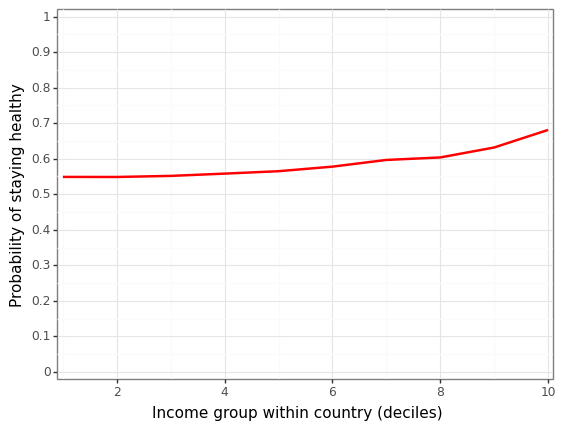

<ggplot: (362530714)>

In [16]:
(
    ggplot(data=share)
    + geom_smooth(
        aes(x="income10", y="stayshealthy"), method="loess", se=False, color="red"
    )
    + labs(
        x="Income group within country (deciles)", y="Probability of staying healthy "
    )
    + scale_x_continuous(expand=[0.01, 0.01], limits=[1, 10], breaks=np.arange(0, 11, 2))
    + scale_y_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=np.arange(0, 1.1, 0.1))
    + theme_bw()
)

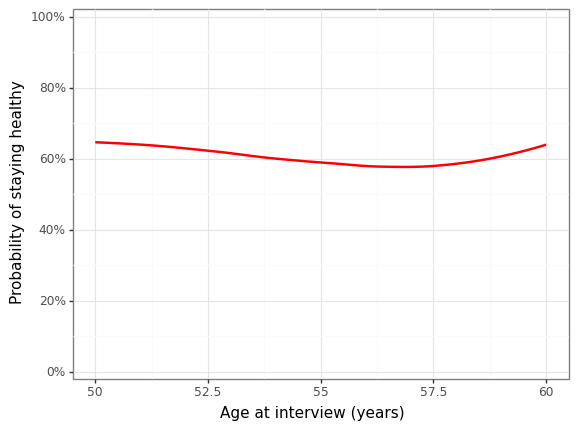

<ggplot: (362748163)>

In [17]:
(
    ggplot(data=share)
    + geom_smooth(
        aes(x="age", y="stayshealthy"), method="loess", se=False, color="red"
    )
    + scale_y_continuous(
        expand=[0.01, 0.01],
        limits=[0, 1],
        breaks=np.arange(0, 1.1, 0.2),
        labels=percent_format(),
    )
    + labs(x="Age at interview (years)", y="Probability of staying healthy")
    + theme_bw()
)

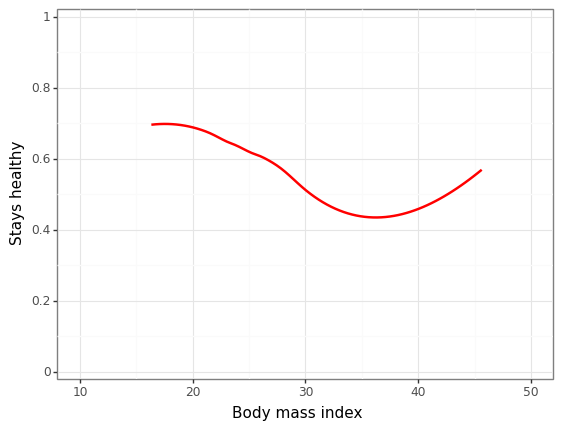

<ggplot: (362761949)>

In [18]:
(
    ggplot(data=share)
    + geom_smooth(aes(x="bmi", y="stayshealthy"), method="loess", se=False, color="red")
    + scale_y_continuous(
        expand=[0.01, 0.01], limits=[0, 1], breaks=np.arange(0, 1.1, 0.2)
    )
    + scale_x_continuous(limits=[10, 50], breaks=np.arange(10, 51, 10))
    + labs(x="Body mass index", y="Stays healthy")
    + theme_bw()
)

### Task:

Linear probability model with many covariates, use the following
     
     smoking, ever_smoked, female, age, eduyears, income10, bmi, exerc, country_str

Use the P.L.S transformations:
   - eduyears: with knots at 8 (elementary only) and 18 (Diploma)
   - bmi: with knot at 35

and include `country` as categories, statsmodel will create dummies aout of them

In [19]:
share['country'] = share['country'].astype('category')

In [20]:
import copy
def lspline(series, knots):
    def knot_ceil(vector, knot):
        vector_copy = copy.deepcopy(vector)
        vector_copy[vector_copy > knot] = knot
        return vector_copy

    if type(knots) != list:
        knots = [knots]
    design_matrix = None
    vector = series.values

    for i in range(len(knots)):
        # print(i)
        # print(vector)
        if i == 0:
            column = knot_ceil(vector, knots[i])
        else:
            column = knot_ceil(vector, knots[i] - knots[i - 1])
        # print(column)
        if i == 0:
            design_matrix = column
        else:
            design_matrix = np.column_stack((design_matrix, column))
        # print(design_matrix)
        vector = vector - column
    design_matrix = np.column_stack((design_matrix, vector))
    # print(design_matrix)
    return design_matrix

In [21]:
lpm3 = smf.ols(
    "stayshealthy ~ smoking + ever_smoked + female + age + lspline(eduyears,[8,18]) + \
                    income10 + lspline(bmi,[35]) + exerc + country",
    share,
).fit(covtype="HC3")

In [22]:
table = Stargazer([lpm1, lpm2, lpm3])
table.covariate_order(
    [
        "smoking",
        "ever_smoked",
        "female",
        "age",
        "lspline(eduyears, [8, 18])[0]",
        "lspline(eduyears, [8, 18])[1]",
        "lspline(eduyears, [8, 18])[2]",
        "income10",
        "lspline(bmi, [35])[0]",
        "lspline(bmi, [35])[1]",
        "exerc",
    ]
)
table

Check predicted probabilities: is there any interesting values?   

In [23]:
share["pred_lpm"] = lpm3.predict()

Make a descriptive summary of the predictions with 3 digits

In [24]:
share['pred_lpm'].describe().round(4)

count    3109.0000
mean        0.6047
std         0.1567
min         0.0361
25%         0.5001
50%         0.6073
75%         0.7134
max         1.0110
Name: pred_lpm, dtype: float64

Show the predicted probabilities' distribution

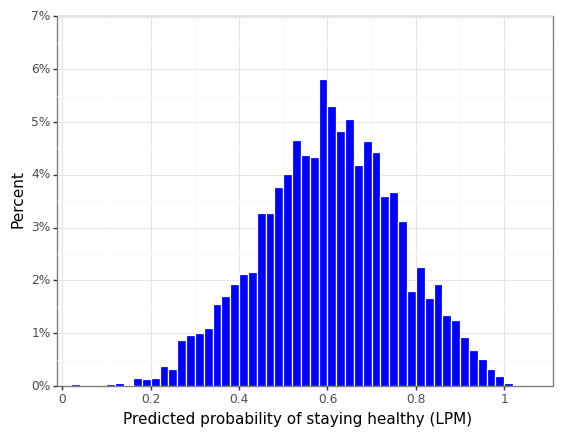

<ggplot: (362834224)>

In [25]:
(
    ggplot(share, aes(x="pred_lpm"))
    + geom_histogram(
        aes(y="stat(count)/sum(stat(count))"),
        binwidth=0.02,
        center=0.65,
        color="white",
        fill="blue",
        closed="right",
        na_rm=True
    )
    + labs(x="Predicted probability of staying healthy (LPM)", y="Percent")
    + scale_y_continuous(
        expand=[0.00, 0.0],
        limits=[0, 0.07],
        breaks=np.arange(0, 0.07, 0.01),
        labels=percent_format(),
    )
    + scale_x_continuous(
        expand=[0.001, 0.01], limits=[0, 1.1], breaks=np.arange(0, 1.1, 0.2)
    )
    + theme_bw()
)

 We are interested in the top 1% and bottom 1% characteristics!
    
   Is there any significant difference?


   Create bins which categorize the predicted values between 1-100


In [26]:
cuts = 100
share["q100_pred_lpm"] = pd.qcut(share["pred_lpm"], q=cuts, labels=range(1, cuts + 1))

Top 1%

In [27]:
share.loc[
    share["q100_pred_lpm"] == 100,
    ["smoking", "ever_smoked", "female", "age", "eduyears", "income10", "bmi", "exerc"],
].describe().round(1)


,smoking,ever_smoked,female,age,eduyears,income10,bmi,exerc
count,32.0,32.0,32.0,32.0,32.0,32.0,32.0,32.0
mean,0.0,0.4,1.0,53.9,17.3,8.9,20.8,0.9
std,0.0,0.5,0.2,2.5,1.5,1.6,1.8,0.3
min,0.0,0.0,0.0,50.6,13.0,4.0,17.2,0.0
25%,0.0,0.0,1.0,52.1,16.0,8.8,19.7,1.0
50%,0.0,0.0,1.0,53.4,17.5,10.0,20.8,1.0
75%,0.0,1.0,1.0,55.2,18.0,10.0,22.1,1.0
max,0.0,1.0,1.0,60.0,20.0,10.0,24.5,1.0


Bottom 1%

In [28]:
share.loc[
    share["q100_pred_lpm"] == 1,
    ["smoking", "ever_smoked", "female", "age", "eduyears", "income10", "bmi", "exerc"],
].describe().round(1)

,smoking,ever_smoked,female,age,eduyears,income10,bmi,exerc
count,32.0,32.0,32.0,32.0,32.0,32.0,32.0,32.0
mean,0.4,0.5,0.4,56.0,7.7,3.8,30.5,0.2
std,0.5,0.5,0.5,2.6,3.3,2.8,3.9,0.4
min,0.0,0.0,0.0,50.4,0.0,1.0,23.0,0.0
25%,0.0,0.0,0.0,53.9,4.8,1.0,28.1,0.0
50%,0.0,0.0,0.0,56.5,8.0,3.0,30.5,0.0
75%,1.0,1.0,1.0,57.8,10.2,6.2,33.9,0.0
max,1.0,1.0,1.0,59.9,14.0,10.0,38.1,1.0


## 3) LOGIT AND PROBIT MODELS

Lets compare:\
   lpm versus logit and probit
 
 with all right-hand-side variables

 If comparing different estimation methods for the same model setup:
   good practice to make a 'formula' variable!

 To have pretty outcomes, we need to create spline variables

In [29]:
formula = "stayshealthy ~ smoking + ever_smoked + female + age + lspline(eduyears,[8,18]) + \
                 income10 + lspline(bmi,[35]) + exerc + country"

Repeat LPM with new formula

In [30]:
lpm = smf.ols(formula, share).fit(covtype="HC3")

table = Stargazer([lpm])
table.covariate_order(
    [
        "smoking",
        "ever_smoked",
        "female",
        "age",
        "lspline(eduyears, [8, 18])[0]",
        "lspline(eduyears, [8, 18])[1]",
        "lspline(eduyears, [8, 18])[2]",
        "income10",
        "lspline(bmi, [35])[0]",
        "lspline(bmi, [35])[1]",
        "exerc",
    ]
)
table

Save predictions

In [31]:
share["pred_lpm"] = lpm.predict()

Logit

In [32]:
logit = smf.logit(formula, share).fit()


table = Stargazer([logit])
table.covariate_order(
    [
        "smoking",
        "ever_smoked",
        "female",
        "age",
        "lspline(eduyears, [8, 18])[0]",
        "lspline(eduyears, [8, 18])[1]",
        "lspline(eduyears, [8, 18])[2]",
        "income10",
        "lspline(bmi, [35])[0]",
        "lspline(bmi, [35])[1]",
        "exerc",
    ]
)
table

Optimization terminated successfully.
         Current function value: 0.617166
         Iterations 5


In [33]:
share["pred_logit"] = logit.predict()

Calculate the Average Marginal Effects 

In [34]:
logit.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:           stayshealthy
Method:                          dydx
At:                           overall
=================================================================================================
                                   dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
country[T.12]                    -0.2106      0.070     -2.993      0.003      -0.349      -0.073
country[T.13]                    -0.0423      0.059     -0.714      0.475      -0.158       0.074
country[T.15]                    -0.1406      0.041     -3.406      0.001      -0.221      -0.060
country[T.16]                    -0.2399      0.039     -6.191      0.000      -0.316      -0.164
country[T.17]                    -0.1682      0.036     -4.701      0.000      -0.238      -0.098
country[T.18]                     0.0934      0.039      2.417      0.016       0.018       0.169
country[T.20]                     0.0146      0.034      0.427      0.670      -0.052       0.081
country[T.23]                    -0.1229      0.033     -3.678      0.000      -0.188      -0.057
country[T.28]                    -0.1618      0.037     -4.345      0.000      -0.235      -0.089
country[T.29]                    -0.3152      0.084     -3.751      0.000      -0.480      -0.150
country[T.33]                    -0.3382      0.063     -5.332      0.000      -0.463      -0.214
country[T.34]                    -0.1972      0.043     -4.538      0.000      -0.282      -0.112
country[T.35]                    -0.2901      0.044     -6.582      0.000      -0.376      -0.204
smoking                          -0.0609      0.023     -2.611      0.009      -0.107      -0.015
ever_smoked                       0.0168      0.020      0.849      0.396      -0.022       0.055
female                            0.0345      0.018      1.968      0.049       0.000       0.069
age                              -0.0026      0.003     -0.859      0.390      -0.009       0.003
lspline(eduyears, [8, 18])[0]    -0.0006      0.007     -0.090      0.928      -0.015       0.013
lspline(eduyears, [8, 18])[1]     0.0170      0.003      5.097      0.000       0.010       0.023
lspline(eduyears, [8, 18])[2]    -0.0098      0.012     -0.825      0.409      -0.033       0.013
income10                          0.0076      0.003      2.461      0.014       0.002       0.014
lspline(bmi, [35])[0]            -0.0123      0.002     -5.109      0.000      -0.017      -0.008
lspline(bmi, [35])[1]             0.0067      0.015      0.439      0.661      -0.023       0.036
exerc                             0.0546      0.017      3.248      0.001       0.022       0.088
=================================================================================================
"""

Probit

In [35]:
probit = smf.probit(formula, share).fit()


table = Stargazer([probit])
table.covariate_order(
    [
        "smoking",
        "ever_smoked",
        "female",
        "age",
        "lspline(eduyears, [8, 18])[0]",
        "lspline(eduyears, [8, 18])[1]",
        "lspline(eduyears, [8, 18])[2]",
        "income10",
        "lspline(bmi, [35])[0]",
        "lspline(bmi, [35])[1]",
        "exerc",
    ]
)
table

Optimization terminated successfully.
         Current function value: 0.617255
         Iterations 5


In [36]:
share["pred_probit"] = probit.predict()

probit marginal differences

In [37]:
probit.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
       Probit Marginal Effects       
=====================================
Dep. Variable:           stayshealthy
Method:                          dydx
At:                           overall
=================================================================================================
                                   dy/dx    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
country[T.12]                    -0.2096      0.071     -2.938      0.003      -0.349      -0.070
country[T.13]                    -0.0397      0.059     -0.678      0.498      -0.155       0.075
country[T.15]                    -0.1411      0.042     -3.386      0.001      -0.223      -0.059
country[T.16]                    -0.2420      0.039     -6.193      0.000      -0.319      -0.165
country[T.17]                    -0.1677      0.036     -4.662      0.000      -0.238      -0.097
country[T.18]                     0.0906      0.037      2.446      0.014       0.018       0.163
country[T.20]                     0.0150      0.034      0.445      0.656      -0.051       0.081
country[T.23]                    -0.1215      0.033     -3.643      0.000      -0.187      -0.056
country[T.28]                    -0.1613      0.038     -4.288      0.000      -0.235      -0.088
country[T.29]                    -0.3094      0.082     -3.764      0.000      -0.470      -0.148
country[T.33]                    -0.3430      0.063     -5.435      0.000      -0.467      -0.219
country[T.34]                    -0.1969      0.044     -4.468      0.000      -0.283      -0.111
country[T.35]                    -0.2916      0.045     -6.536      0.000      -0.379      -0.204
smoking                          -0.0601      0.023     -2.575      0.010      -0.106      -0.014
ever_smoked                       0.0156      0.020      0.793      0.428      -0.023       0.054
female                            0.0343      0.018      1.957      0.050   -5.49e-05       0.069
age                              -0.0029      0.003     -0.956      0.339      -0.009       0.003
lspline(eduyears, [8, 18])[0]    -0.0007      0.007     -0.102      0.918      -0.015       0.013
lspline(eduyears, [8, 18])[1]     0.0168      0.003      5.074      0.000       0.010       0.023
lspline(eduyears, [8, 18])[2]    -0.0101      0.012     -0.864      0.387      -0.033       0.013
income10                          0.0076      0.003      2.453      0.014       0.002       0.014
lspline(bmi, [35])[0]            -0.0122      0.002     -5.060      0.000      -0.017      -0.007
lspline(bmi, [35])[1]             0.0060      0.015      0.388      0.698      -0.024       0.036
exerc                             0.0532      0.017      3.161      0.002       0.020       0.086
=================================================================================================
"""

Comparing predictions from the three models

In [38]:
share.filter(["pred_lpm","pred_logit","pred_probit"]).describe().T

,count,mean,std,min,25%,50%,75%,max
pred_lpm,3109.0,0.604696,0.156665,0.036103,0.500122,0.607342,0.713423,1.011026
pred_logit,3109.0,0.604696,0.157277,0.107760,0.496971,0.614335,0.723092,0.920142
pred_probit,3109.0,0.604763,0.156611,0.103114,0.498824,0.612903,0.720459,0.930006


Creating a model summary output for base models

In [39]:
table = Stargazer([lpm,logit,probit])
table.covariate_order(
    [
        "smoking",
        "ever_smoked",
        "female",
        "age",
        "lspline(eduyears, [8, 18])[0]",
        "lspline(eduyears, [8, 18])[1]",
        "lspline(eduyears, [8, 18])[2]",
        "income10",
        "lspline(bmi, [35])[0]",
        "lspline(bmi, [35])[1]",
        "exerc",
    ]
)
table

## 4) Goodness of Fit (GoF) statistics 
       with binary models

 goodness of fit is the same for marginal effects 
   as the base models, as it only calculates some averaged effects.

Lets import some metrics from the sklearn package

In [40]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import log_loss

In [41]:
pd.DataFrame(
    {
        "R-squared": [
            lpm.rsquared,
            r2_score(share["stayshealthy"], share["pred_logit"]),
            r2_score(share["stayshealthy"], share["pred_probit"]),
        ],
        "Brier-score": [
            mean_squared_error(share["stayshealthy"], share["pred_lpm"]),
            mean_squared_error(share["stayshealthy"], share["pred_logit"]),
            mean_squared_error(share["stayshealthy"], share["pred_probit"]),
        ],
        "Pseudo R-squared": [np.nan, logit.prsquared, probit.prsquared],
        "Log-loss": [
            -1 * log_loss(share["stayshealthy"], share["pred_lpm"]),
            -1 * log_loss(share["stayshealthy"], share["pred_logit"]),
            -1 * log_loss(share["stayshealthy"], share["pred_probit"]),
        ],
    },
    index=["LPM", "Logit", "Probit"],
).T.round(3)

,LPM,Logit,Probit
R-squared,0.103,0.104,0.104
Brier-score,0.215,0.214,0.214
Pseudo R-squared,NaN,0.080,0.080
Log-loss,-0.620,-0.617,-0.617


## 5) Visual inspection for model comparisons

 a) Comparing predicted probabilities of logit and probit to LPM

First, we need some data manipulation to convert wide to long

In [42]:
df_plot = pd.melt(
    share[["pred_lpm", "pred_logit", "pred_probit"]].rename(
        columns={"pred_logit": "Logit", "pred_probit": "Probit"}
    ),
    value_vars=["Logit", "Probit"],
    id_vars=["pred_lpm"],
).sort_values(by=["variable"], ascending=False)


In [43]:
df_plot.head()

,pred_lpm,variable,value
3109,0.654021,Probit,0.655557
4130,0.644235,Probit,0.653171
4152,0.588621,Probit,0.596055
4151,0.393780,Probit,0.377629
4150,0.340910,Probit,0.325872


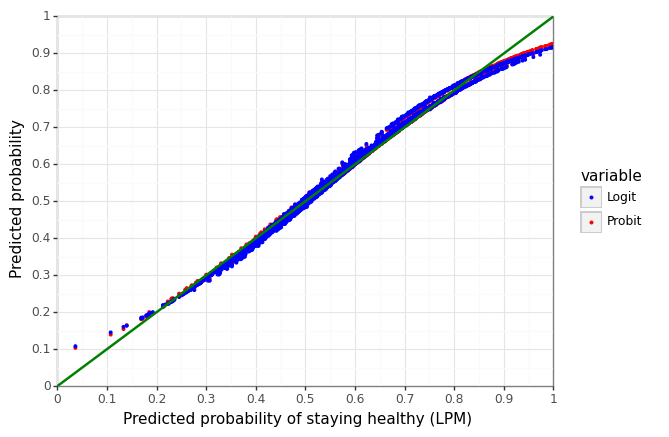

<ggplot: (363131808)>

In [44]:
(
    ggplot(data=df_plot)
    + geom_point(aes(x="pred_lpm", y="value", color="variable"), size=0.6, na_rm=True)
    + geom_abline(intercept=0, slope=1, color="green", size=1)
    + labs(
        x="Predicted probability of staying healthy (LPM)", y="Predicted probability"
    )
    + scale_y_continuous(
        expand=[0.00, 0.0], limits=[0, 1], breaks=np.arange(0, 1.1, 0.1)
    )
    + scale_x_continuous(
        expand=[0.00, 0.0], limits=[0, 1], breaks=np.arange(0, 1.1, 0.1)
    )
    + scale_color_manual(name="", values=["blue", "red"])
    + theme_bw()
)

b) Comparing simple LPM and rich LPM's categorization

In [45]:
lpmbase = smf.ols('stayshealthy ~ smoking', data=share).fit()
share['pred_lpmbase']=lpmbase.predict()

 b1) LPM simple model

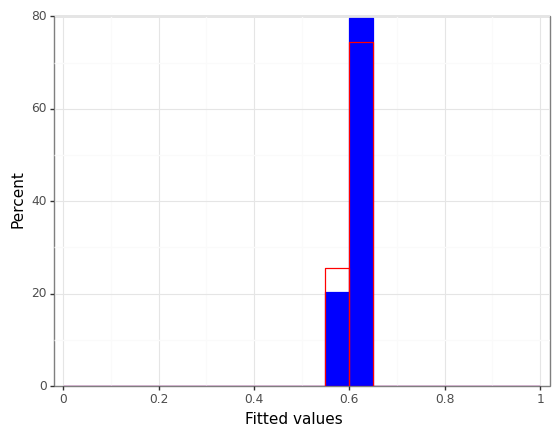

<ggplot: (362414540)>

In [46]:
(
    ggplot(
        share,
        aes(x="pred_lpmbase", fill="stayshealthy", y="stat(count/sum(count)))*100"),
    )
    + geom_histogram(
        share[share["stayshealthy"] == 1],
        binwidth=0.05,
        color="blue",
        fill="blue",
        boundary=0.55,
    )
    + geom_histogram(
        share[share["stayshealthy"] == 0],
        binwidth=0.05,
        color="red",
        fill=None,
        boundary=0.55,
    )
    + ylab("Percent")
    + xlab("Fitted values")
    + scale_x_continuous(
        expand=[0.01, 0.01], limits=[0, 1], breaks=np.arange(0, 1.1, 0.2)
    )
    + scale_y_continuous(
        expand=[0.00, 0.00], limits=[0, 80], breaks=np.arange(0, 81, 20)
    )
    + theme_bw()
    + theme(legend_position=(0.3, 0.8))
)

b2) LPM rich model

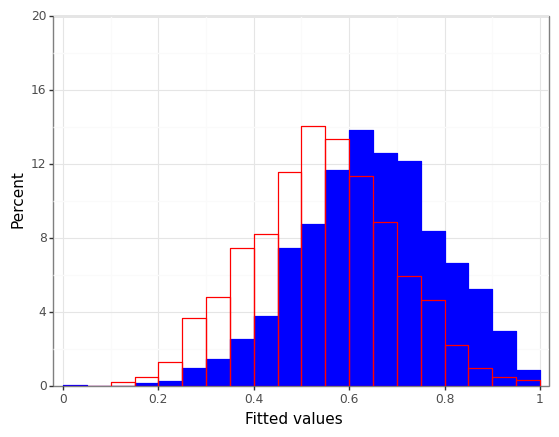

<ggplot: (363273397)>

In [47]:
(
    ggplot(
        share,
        aes(x="pred_lpm", fill="stayshealthy", y="stat(count/sum(count)))*100"),
    )
    + geom_histogram(
        share[share["stayshealthy"] == 1],
        binwidth=0.05,
        color="blue",
        fill="blue",
        boundary=0.55,
        na_rm=True
    )
    + geom_histogram(
        share[share["stayshealthy"] == 0],
        binwidth=0.05,
        color="red",
        fill=None,
        boundary=0.55,
    )
    + ylab("Percent")
    + xlab("Fitted values")
    + scale_x_continuous(expand=[0.01, 0.01], limits=[0, 1], breaks=np.arange(0, 1.1, 0.2))
    + scale_y_continuous(expand=[0.00, 0.00], limits=[0, 20], breaks=np.arange(0, 21, 4))
    + theme_bw()
)


## 6) Summary statistics on predicted probabilities

## Task:

Create a CONDITIONAL descriptive statistics on stayhealth for:

    "pred_lpmbase","pred_lpm","pred_logit","pred_probit" 
   
use: "mean","median","min","max","sd" as descriptives

In [48]:
(
    share.melt(
        id_vars=["stayshealthy"],
        value_vars=["pred_lpmbase", "pred_lpm", "pred_logit", "pred_probit"],
    )
    .groupby(["stayshealthy", "variable"])["value"]
    .agg(["mean", "median", "min", "max", "std"])
)

mean    median       min       max       std
stayshealthy variable                                                      
0            pred_logit    0.541993  0.543988  0.145075  0.916548  0.152913
             pred_lpm      0.542627  0.543480  0.107263  0.998544  0.148973
             pred_lpmbase  0.602536  0.620390  0.550287  0.620390  0.030555
             pred_probit   0.542372  0.544583  0.139130  0.925826  0.151568
1            pred_logit    0.645687  0.654917  0.107760  0.920142  0.146222
             pred_lpm      0.645272  0.646661  0.036103  1.011026  0.148076
             pred_lpmbase  0.606108  0.620390  0.550287  0.620390  0.028242
             pred_probit   0.645549  0.653014  0.103114  0.930006  0.146100

## 7) Bias and Calibration curve

Lets use the logit model!

 Biased prediction? Calculate bias!
 
 
   Hint: bias = mean(prediction) - mean(actual)
   
   calibration curves -> essentially a scatter-bin!

In [49]:
breaks = np.array(
    [
        0,
        0.2,
        0.25,
        0.3,
        0.35,
        0.4,
        0.45,
        0.5,
        0.55,
        0.6,
        0.65,
        0.7,
        0.75,
        0.8,
        0.85,
        1.05,
    ]
)

Create binned data:

In [50]:
share["prob_bin"] = pd.cut(share["pred_logit"], breaks, right=True, include_lowest=True)

In [51]:
binned_data = (
        share.groupby("prob_bin")
        .agg(
            mean_prob=("pred_logit", "mean"),
            mean_actual=("stayshealthy", "mean"),
            n=("stayshealthy", "size"),
        )
        .reset_index()
    )


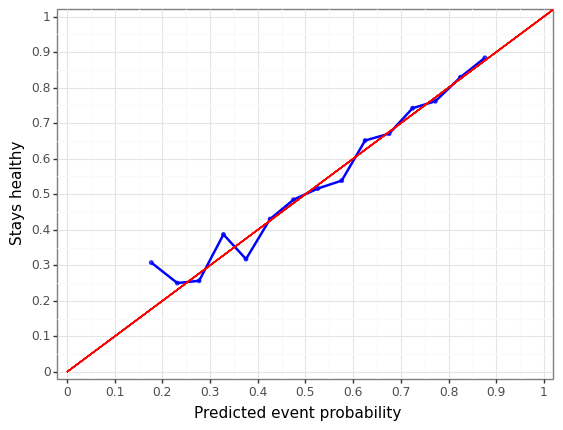

<ggplot: (363312498)>

In [52]:
(
    ggplot(binned_data, aes("mean_prob", "mean_actual"))
    + geom_line(color="blue", size=1, show_legend=True)
    + geom_point(
        color="blue",
        size=1,
        alpha=0.7,
        show_legend=False,
        na_rm=True,
    )
    + geom_segment(
        x=min(breaks),
        xend=max(breaks),
        y=min(breaks),
        yend=max(breaks),
        color="red",
        size=0.5,
    )
    + theme_bw()
    + labs(x="Predicted event probability", y="Stays healthy")
    + coord_cartesian(xlim=(0, 1), ylim=(0, 1))
    + expand_limits(x=0.01, y=0.01)
    + scale_y_continuous(expand=(0.01, 0.01), breaks=(np.arange(0, 1.1, 0.1)))
    + scale_x_continuous(expand=(0.01, 0.01), breaks=(np.arange(0, 1.1, 0.1)))
)

## Task

Do the same calibration curve, but now for LPM rich model\
   Make sure that in the plot you also show the Logit-bias as well

In [53]:
share["prob_bin"] = pd.cut(share["pred_lpm"], breaks, right=True, include_lowest=True)

In [54]:
binned_data2 = (
        share.groupby("prob_bin")
        .agg(
            mean_prob_lpm=("pred_lpm", "mean"),
            mean_actual_lpm=("stayshealthy", "mean"),
            n=("stayshealthy", "size"),
        )
        .reset_index()
    )


Join the two data for pretty plot

In [55]:
binned_data = binned_data.merge(binned_data2, on = "prob_bin")

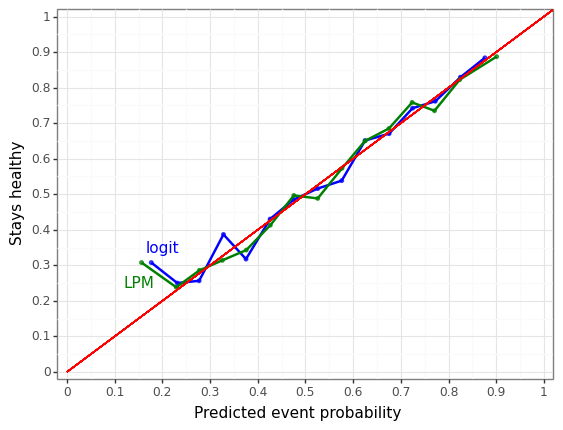

<ggplot: (362615730)>

In [56]:
(
    ggplot(binned_data)
    + geom_line(aes("mean_prob", "mean_actual"), color="blue", size=1, show_legend=True)
    + geom_point(
        aes("mean_prob", "mean_actual"),
        color="blue",
        size=1,
        alpha=0.7,
        show_legend=False,
        na_rm=True,
    )
    + geom_segment(
        x=min(breaks),
        xend=max(breaks),
        y=min(breaks),
        yend=max(breaks),
        color="red",
        size=0.5,
    )
    + geom_line(
        aes("mean_prob_lpm", "mean_actual_lpm"), color="green", size=1, show_legend=True
    )
    + geom_point(
        aes("mean_prob_lpm", "mean_actual_lpm"),
        color="green",
        size=1,
        alpha=0.7,
        show_legend=False,
        na_rm=True,
    )
    + geom_segment(
        x=min(breaks),
        xend=max(breaks),
        y=min(breaks),
        yend=max(breaks),
        color="red",
        size=0.5,
    )
    + theme_bw()
    + labs(x="Predicted event probability", y="Stays healthy")
    + annotate(
        "text",
        x=(0.2, 0.15),
        y=(0.35, 0.25),
        label=("logit", "LPM"),
        color=("blue", "green"),
    )
    + coord_cartesian(xlim=(0, 1), ylim=(0, 1))
    + expand_limits(x=0.01, y=0.01)
    + scale_y_continuous(expand=(0.01, 0.01), breaks=(np.arange(0, 1.1, 0.1)))
    + scale_x_continuous(expand=(0.01, 0.01), breaks=(np.arange(0, 1.1, 0.1)))
)